# History Searcher
i created this langgraph worflow for searching history by calling wikipedia tool

In [ ]:
!pip install langgraph langsmith langchain langchain_community langchain_groq

In [ ]:
from typing_extensions import Annotated
from typing_extensions import TypedDict
!pip install arxiv wikipedia

In [ ]:

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki_tool.invoke("who is qaid e azam")

'Page: Muhammad Ali Jinnah\nSummary: Muhammad Ali Jinnah (born Mahomedali Jinnahbhai; 25 December 1876 – 11 September 1948) was a barrister, politician, and the founder of Pakistan. Jinnah served as the leader of the All-India Muslim League from 1913 until the inception of Pakistan on 14 August 1947 a'

In [ ]:
tools = [wiki_tool]

In [ ]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [ ]:
from langgraph.graph import StateGraph,START,END

In [ ]:
graph_builder= StateGraph(State)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY
)

response = llm.invoke

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

In [ ]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")
graph=graph_builder.compile()

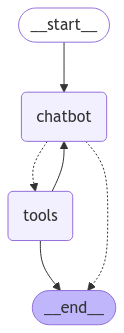

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
user_input="Hi there!, who is babar azam"
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

In [ ]:
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, who is babar azam
================================== Ai Message ==================================
Tool Calls:
  wikipedia (b022a090-2977-4541-8542-689b4476186e)
 Call ID: b022a090-2977-4541-8542-689b4476186e
  Args:
    query: babar azam
================================= Tool Message =================================
Name: wikipedia

Page: Babar Azam
Summary: Mohammad Babar Azam (Urdu, Punjabi: محمد بابر اعظم; pronounced [Muhamməd babəɾ azəm]; born 15 October 1994) is a Pakistani international cricketer and the former captain of the Pakistan national cricket team in all three formats of the game. A right-handed top-order batter,
================================== Ai Message ==================================

Babar Azam is a Pakistani international cricketer and the former captain of the Pakistan national cricket team.  He is a right-handed top-order batter.
